In [225]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils
import cv2

from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [226]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
path = 'drive/MyDrive/master/CSS 433/data' #Jade
for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy


In [ ]:
# IMAGE DATA
time_image = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
ground_truth = np.load(os.path.join(path, 'ground_truth.npy'),allow_pickle=True)
labels = ghi_dataset.labels

# Extract day, month, and year using list comprehension
date_info_image = [(dt.day, dt.month, dt.year) if isinstance(dt, datetime) else
                   (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year)
                   for dt in time_image]

# List comprehension to extract day values for all dates
day_values_image = [day for day, _, _ in date_info_image]
month_values_image = [month for _, month, _ in date_info_image]
year_values_image = [year for _ , _, year in date_info_image]
month_and_year_values_image = [(month, year) for _, month, year in date_info_image]

# METEO DATA
# Construct the full path to the Excel file
file_path = os.path.join(path, 'meteo.xlsx')
# Use pandas to read the Excel file
df = pd.read_excel(file_path)

date = df['Date'].values
time_meteo = df['Time'].values
real_time_ch = df['Real_time_CH'].values
air_temp = df['Air_temp'].values
wind_speed = df['Wind_speed'].values
wind_dir = df['Wind_dir'].values

# Extract day, month, and year using list comprehension
date_info = [(datetime.strptime(date_, '%d.%m.%Y').day,
              datetime.strptime(date_, '%d.%m.%Y').month,
              datetime.strptime(date_, '%d.%m.%Y').year) for date_ in date]

# List comprehension to extract day values for all dates
day_values_meteo = [day for day, _, _ in date_info]
month_values_meteo = [month for _, month, _ in date_info]
year_values_meteo = [year for _ , _, year in date_info]
month_and_year_values_meteo = [(month, year) for _, month, year in date_info]

In [227]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, transform_input=None, transform_label=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            transform_input (callable, optional): Optional transform to be applied on a sample. .
            transform_label (callable, optional): Optional transform to be applied on the label.
        """

        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels)))
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_input = transform_input
        self.transform_label = transform_label

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the images that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        # Apply the transforms
        if self.transform_input:
            image0 = self.transform_input(image0)
            image1 = self.transform_input(image1)

        if self.transform_label:
            labels = self.transform_label(labels)


        # Returns the sample as a tuple of (image0, image1, lables)
        return image0,image1,labels

Function for displaying a sample

In [228]:
def sample_display(image1,image2, label):
  # The image is a now a Torch vector, it needs to be reshaped for display
  plt.imshow(image1.permute(1,2,0))
  print("Label : ", label.item())

In [229]:
img_size = 100

# Create a transform, it converts the np.array to a PIL Image,
# then resize the image to img_size x img_size, then converts the image to tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Creates the dataset containing all the samples
ghi_dataset = GHIDataset(path,'labels.npy','X.npy',transform)

Small example to display a few samples

0 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
Label :  133.0
1 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
Label :  127.0
2 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
Label :  140.0
3 torch.Size([3, 100, 100]) torch.Size([3, 100, 100]) torch.Size([])
Label :  141.0


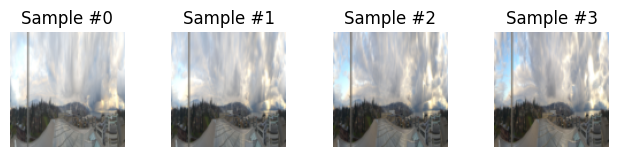

In [230]:
sample_size = 4

for i, sample in enumerate(ghi_dataset):
    print(i, sample[0].shape, sample[1].shape, sample[2].shape)

    ax = plt.subplot(1, sample_size, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    sample_display(*sample) #display image and label

    if i == (sample_size-1):
        plt.show()
        break

Here we define a function to split the dataset into a test set, a validation set and a train set.

Note that we do not shuffle the data as it is time dependent. What is significant here is that we test for the last values of the set.

We will define later another function in case of cross validation

In [231]:
def split_at_locatio__(dataset, location = 0, sample = 1, val_split = 0.05):
    """
        Arguments:
            location  (float) : position in the dataset to start to cut
            val_split (float) : per cent of the dataset to cut
        """
    size = round(val_split*len(dataset))

    # Calculate start and stop indices while preventing out-of-range
    start_idx = 0
    end_idx = min(val_split*size,len(dataset))

    for i in range(sample):
      start_idx = max(0,location)
      end_idx = min(location + val_split*size,len(dataset))

      # Take the 5% subset
      subset = train_idx[start_idx:end_idx]

      # Create the modified training set without the 5%
      modified_train = np.concatenate([train_idx[:start_idx], train_idx[end_idx:]])

    return Subset(dataset, modified_train), Subset(dataset, subset)

In [232]:
def split_at_location(dataset, location = 0, lenght = 100):
    """
        Arguments:
            location  (float) : position in the dataset to start to cut
            val_split (float) : per cent of the dataset to cut
        """
    train_idx = np.arange(len(dataset))
    # Calculate start and stop indices while preventing out-of-range
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+lenght)



    subset = train_idx[start_idx:end_idx]

      # Create the modified training set without the 5%
    modified_train = np.concatenate([train_idx[:start_idx], train_idx[end_idx:]])

    return Subset(dataset, modified_train), Subset(dataset, subset)

In [233]:
def train_val_dataset(dataset,test_split=0.8, val_split=0.2): # split dataset in train set, validation set, test set
    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def train_val_dataset_original(dataset,test_split=0.2, val_split=0.2): # split dataset in train set, validation set, test set
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

In [234]:
location = 1270

ghi_train, ghi_test = split_at_location(ghi_dataset, location, 400)
ghi_val,ghi_train = split_at_location(ghi_train, 0, round(len(ghi_train)*0.90))

print(len(ghi_train))
print(len(ghi_test))
print(len(ghi_val))

9264
400
1029


Finally we create the dataloader in order to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride between each batch to be one and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

In [235]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler

class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        yield self.data_source[i:i+self.batch_size]
        i += self.dec


train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))
val_loader = DataLoader(ghi_val, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_val)), batch_size=32, dec = 32))

From here this is not yet working, but until here it works as intended, meaning that if I did something wrong it should be conceptual and not in the code.

In [236]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=3) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout2d(p=0.1)
        self.lstm1 = nn.LSTM(32* 22* 22, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x1,x2): #x1 and x2 correspond to the 2 images
        x = torch.cat((x1, x2), dim=1)  # Concatenate along the channel dimension
        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 32* 22* 22)
        x = x.unsqueeze(1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        x = x.squeeze()
        return x


In [237]:
class Net2(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=3) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout2d(p=0.1)
        self.lstm1 = nn.LSTM(32* 22* 22, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x1,x2): #x1 and x2 correspond to the 2 images
        x = torch.cat((x1, x2), dim=1)  # Concatenate along the channel dimension
        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 32* 22* 22)
        x = x.unsqueeze(1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        x = x.squeeze()
        return x


I asked ChatGPT to give me a basic transformer architecture for what we want

In [238]:
class TransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, dropout):
        super(TransformerNet, self).__init__()

        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_size,
                nhead=num_heads,
                dim_feedforward=hidden_size,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        # Fully-connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(256, 32)  # Assuming 8-bit images

        # Create two instances of the TransformerNet
        self.transformer_net1 = TransformerNet(input_size=32, hidden_size=64, num_heads=4, num_layers=2, dropout=0.1)
        self.transformer_net2 = TransformerNet(input_size=32, hidden_size=64, num_heads=4, num_layers=2, dropout=0.1)

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)

        # Reshape to (batch_size, sequence_length, input_size)
        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)

        # Forward through the Transformer networks
        x1 = self.transformer_net1(x1)
        x2 = self.transformer_net2(x2)

        # Concatenate the outputs
        x = torch.cat((x1, x2), dim=1)

        return x

In [239]:
def train_epoch(model, optimizer, criterion, train_loader, epoch, device):
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()
    loss_history = []
    lr_history = []
    # loop to get batch_idx, data and target from train_loader
    for batch_idx, (image0, image1, target) in enumerate(train_loader):

        # Move the data to the device
        image0,image1, target = image0.to(device),image1.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute model output
        output = model(image0,image1)
        output = output.to(torch.float64)
        # Compute loss
        loss = criterion(output, target)
        # Backpropagate loss
        loss.backward()
        # Perform an optimizer step
        optimizer.step()
        # Compute loss (float value, not a tensor)
        loss_float = loss.item()

        loss_history.append(loss_float)
        #if batch_idx % 100 == 0:
        #    print(
        #        f"Train Epoch: {epoch}-{batch_idx:03d} "
        #        f"batch_loss={loss_float:0.2e} "
        #    )
    print(
      f"Train Epoch : {epoch}"
      f"train_loss = {np.mean(loss_history)} "
    )

    return loss_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    history = []

    for image0, image1, target in val_loader:
        image0,image1, target = image0.to(device),image1.to(device), target.to(device)
        output = model(image0,image1)
        test_loss = criterion(output, target).item()
        history.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}".format(
            np.mean(history),
            len(val_loader.dataset)
        )
    )
    return history


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for image0, image1, target in val_loader:
        image0,image1, target = image0.to(device),image1.to(device), target.to(device)
        output = model(image0,image1)
        loss = criterion(output, target)

        data = np.split(data.cpu().numpy(), len(output))
        loss = np.split(loss.cpu().numpy(), len(output))
        pred = np.split(pred.cpu().numpy(), len(output))
        target = np.split(target.cpu().numpy(), len(output))
        points.extend(zip(image0,image1, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points

In [240]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
num_epochs = 50

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = model.to(device=device)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs) # why not AdamW

def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss

best_val_loss = float('inf')  # Initialize with positive infinity
best_epoch = 0  # Initialize with positive infinity


# ===== Train Model =====
train_loss_history = []
train_loss_step = []
val_loss_history = []
val_loss_step = []
for epoch in range(1, num_epochs + 1):
  train_loss = train_epoch(
      model, optimizer, criterion, train_loader, epoch, device
  )
  train_loss_history.extend(train_loss)
  #train_loss_step.append(train_loss[-1])
  train_loss_step.append(np.mean(train_loss))

  val_loss = validate(model, device, val_loader, criterion)
  val_loss_history.extend(val_loss)
  #val_loss_step.append(val_loss[-1])
  loss = np.mean(val_loss)
  val_loss_step.append(loss)

  # Save the model with the lowest validation loss
  if loss < best_val_loss:
      best_val_loss = loss
      best_epoch = epoch
      best_model_state = model.state_dict()

# Load the best model parameters
model.load_state_dict(best_model_state)
print("best loss",best_val_loss, "epoch", best_epoch)


Train Epoch: 1train_loss=330.7088526078332 
Test set: Average loss: 100.7005
Train Epoch: 2train_loss=265.36444129705694 
Test set: Average loss: 74.2733
Train Epoch: 3train_loss=190.60920667253143 
Test set: Average loss: 73.2572
Train Epoch: 4train_loss=144.44161051171278 
Test set: Average loss: 80.5986
Train Epoch: 5train_loss=122.78240140141277 
Test set: Average loss: 73.1455
Train Epoch: 6train_loss=118.3793516143411 
Test set: Average loss: 75.2421
Train Epoch: 7train_loss=111.94054360367998 
Test set: Average loss: 73.0170
Train Epoch: 8train_loss=111.17758380079002 
Test set: Average loss: 74.1993
Train Epoch: 9train_loss=111.55538890428544 
Test set: Average loss: 77.1605
Train Epoch: 10train_loss=107.26856324364788 
Test set: Average loss: 81.3554
Train Epoch: 11train_loss=109.33927358862564 
Test set: Average loss: 83.6519
Train Epoch: 12train_loss=109.2716291386172 
Test set: Average loss: 84.9657
Train Epoch: 13train_loss=105.17621009675129 
Test set: Average loss: 82.61

Text(0, 0.5, 'Loss')

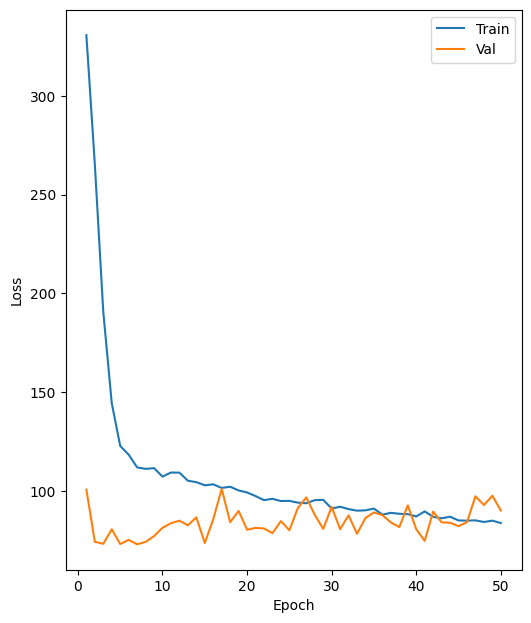

In [241]:
# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.plot(t_val, val_loss_step, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

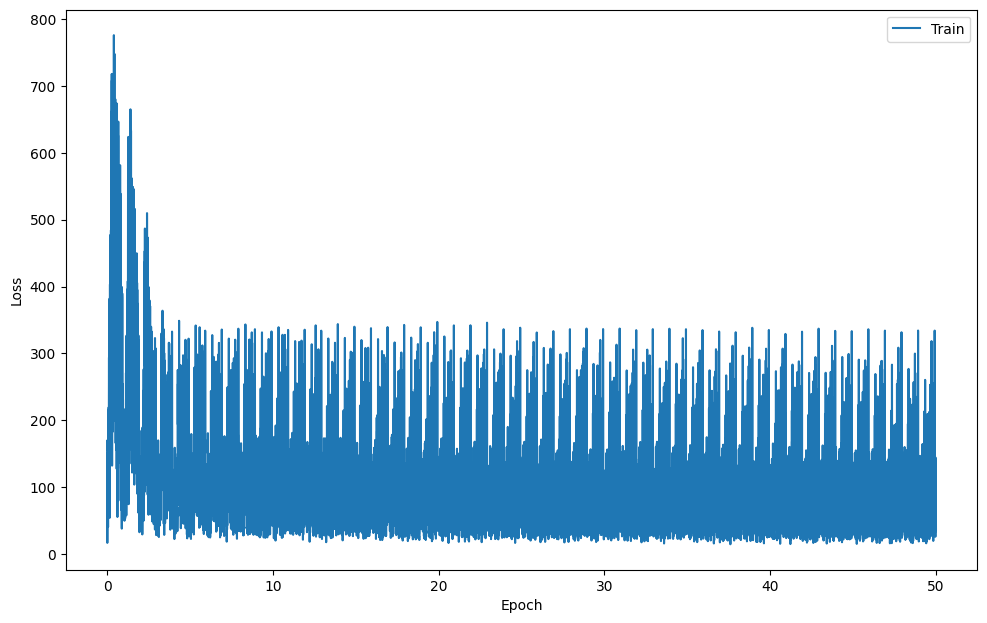

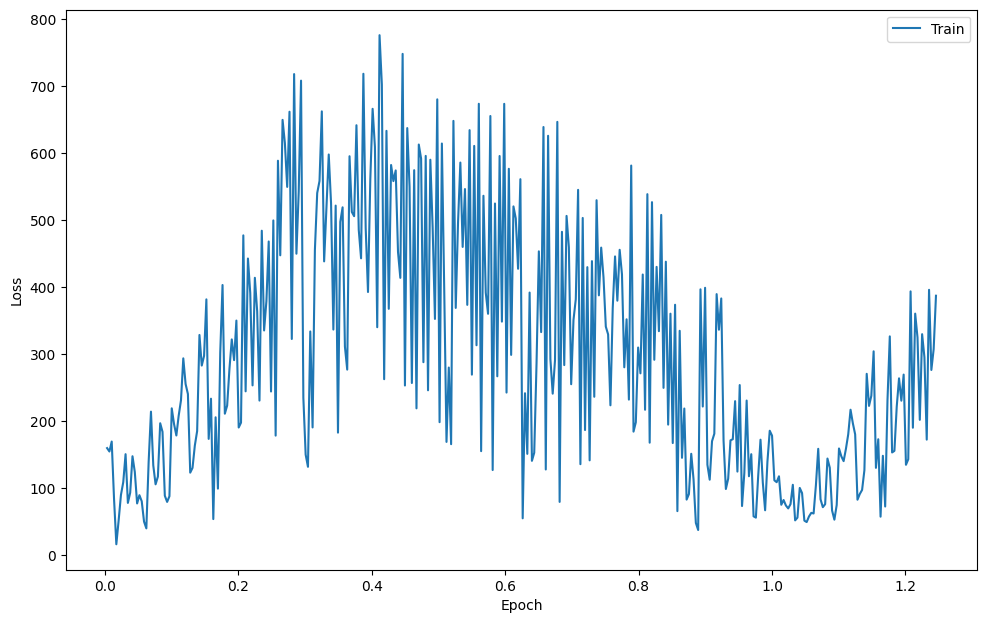

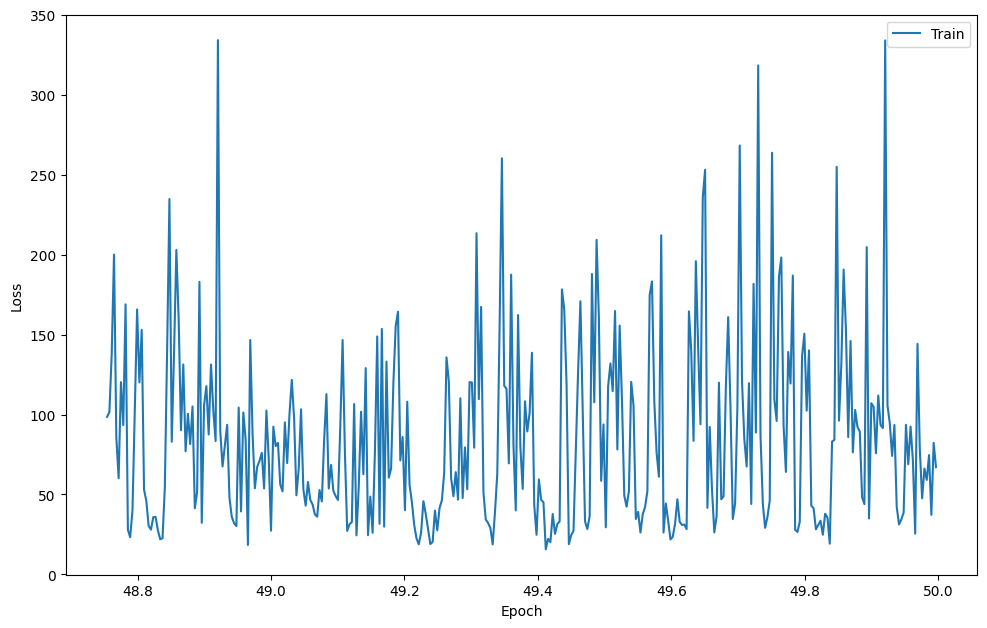

In [242]:
# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

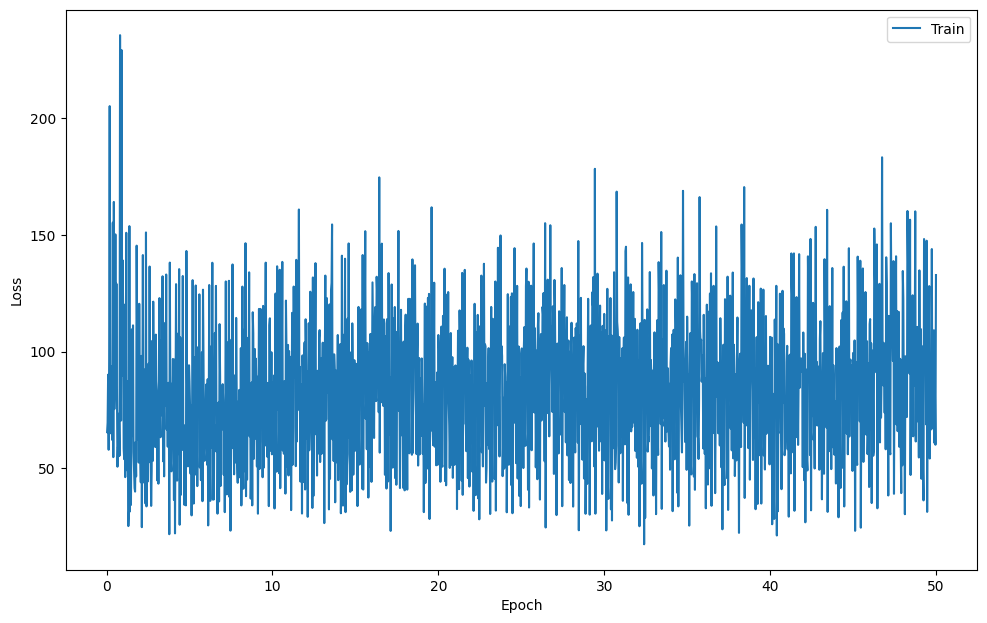

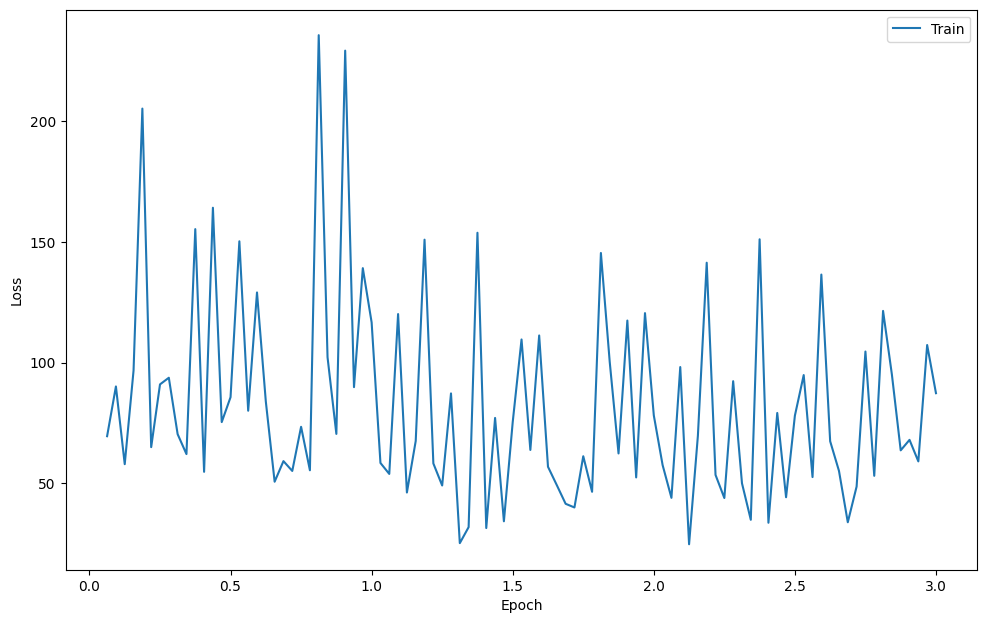

In [243]:
# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_valid = np.arange(1, len(val_loss_history) + 1)/len(val_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_valid, val_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_valid = np.arange(1, len(val_loss_history) + 1)/len(val_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_valid[1:round(len(val_loss_history)/num_epochs*3)], val_loss_history[1:round(len(val_loss_history)/num_epochs)*3], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

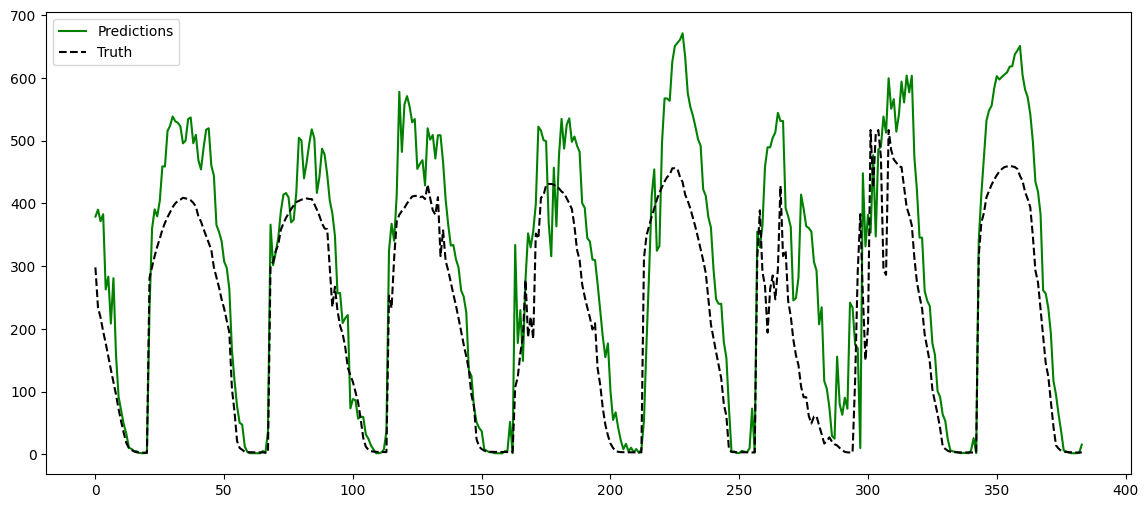

In [244]:
pred = []
truth = []
model.eval()
for image0, image1, target in test_loader:
  image0,image1, target = image0.to(device),image1.to(device), target.to(device)
  output = model(image0,image1)
  pred.extend(output.tolist())
  truth.extend(target.tolist())

#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')